In [1]:

import tensorflow as tf
import numpy as np
import random
import os

In [2]:
# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow


In [3]:
# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms


In [4]:
# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [5]:
# import os
import scipy.io #to load matlab files 
# import numpy as np
from sklearn.model_selection import train_test_split #for data splitting #, KFold
from sklearn.metrics import confusion_matrix
# import tensorflow as tf
from tensorflow.keras import layers, models #build and train CNN model
import matplotlib.pyplot as plt #for plotting confusion matrices and accuracy metrics
import seaborn as sns 
# import pandas as pd

from scipy import signal #for computing spectograms
from skimage.transform import resize #for resizing data
from sklearn.model_selection import StratifiedKFold

In [6]:
"""
# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------
"""
def ImportData():
  folder_path = 'CWRU_BearingData_Load_1HP' 
  # X99_normal = scipy.io.loadmat('content/drive/MyDrive/BearingData_CaseWestern/99.mat')['X099_DE_time'] 
  file_path1 = os.path.join(folder_path, '98.mat')
  X098_normal = scipy.io.loadmat(file_path1)['X098_DE_time'] #vibration data extracted from X099_DE_time key (drive-end accelerometer data)

 

  file_path2 = os.path.join(folder_path, '110.mat')
  X110_InnerRace_007  = scipy.io.loadmat(file_path2)['X110_DE_time']
  # mat_data = scipy.io.loadmat(file_path2)
  # print(mat_data.keys())

  file_path2 = os.path.join(folder_path, '123.mat')
  X123_Ball_007  = scipy.io.loadmat(file_path2)['X123_DE_time']

  file_path3 = os.path.join(folder_path, '136.mat')
  X136_Outer_007 = scipy.io.loadmat(file_path3)['X136_DE_time']

  file_path6 = os.path.join(folder_path, '175.mat')
  X175_InnerRace_014 = scipy.io.loadmat(file_path6)['X175_DE_time']
    
  file_path7 = os.path.join(folder_path, '190.mat')
  X190_Ball_014 = scipy.io.loadmat(file_path7)['X190_DE_time']

  file_path8 = os.path.join(folder_path, '202.mat')
  X202_Outer_014  = scipy.io.loadmat(file_path8)['X202_DE_time']
    
  file_path9 = os.path.join(folder_path, '214.mat')
  X214_InnerRace_021  = scipy.io.loadmat(file_path9)['X214_DE_time']

  file_path10 = os.path.join(folder_path, '227.mat')
  X227_Ball_021  = scipy.io.loadmat(file_path10)['X227_DE_time'] 

  file_path11 = os.path.join(folder_path, '239.mat')
  X239_Outer_021  = scipy.io.loadmat(file_path11)['X239_DE_time'] 
    
  return [X098_normal,X110_InnerRace_007,X123_Ball_007,X136_Outer_007,X175_InnerRace_014,X190_Ball_014,X202_Outer_014,X214_InnerRace_021,X227_Ball_021,X239_Outer_021]

In [7]:
"""
# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction
# -----------------------------------------------------------------------------
"""
# def Sampling(Data, interval_length, samples_per_block):
#     No_of_blocks = (round(len(Data)/interval_length) - round(samples_per_block/interval_length) - 1)
#     SplitData = np.zeros([No_of_blocks, samples_per_block])
#     for i in range(No_of_blocks):
#         SplitData[i,:] = Data[i*interval_length:(i*interval_length)+samples_per_block].T
#     return SplitData

#segments the time-series data into smaller blocks for processing
#data: 1D numpy array of vibration data
#interval length: step size (in samples) betweeen the start of consectuive blocks
#samples_per_block: no. of samples in each block (fixed at 1600 in the code)
#ignore_points: no. of points to skip at start and end of data(default is 0)
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    # Adjust data length to ignore the first and last 'ignore_points'
    adjusted_length = len(Data) - 2 * ignore_points
    # Adjust the number of blocks
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block]) #splitdata matrix where each row is a block of samples_per_block samples
    
    for i in range(No_of_blocks):
        # Skip the first 'ignore_points' and start sampling from that position
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T #.T transpose ensure the data is correctly oriented (since the input is a column vector)
    
    return SplitData #2D array of shape - no.ofblocks, samples_per_block)


def DataPreparation(Data, interval_length, samples_per_block):
  for count,i in enumerate(Data):
    SplitData = Sampling(i, interval_length, samples_per_block) #for each dataset calls samplying to create blocks of 1600 samples
    y = np.zeros([len(SplitData),10]) #y (one-hot encoded): Shape (No_of_blocks, 10), where the column corresponding to the class is set to 1 (e.g., for class 0, [1, 0, 0, ..., 0])
    y[:,count] = 1
    y1 = np.zeros([len(SplitData),1]) #y1 (integer labels): Shape (No_of_blocks, 1), where each element is the class index (0 to 9).
    y1[:,0] = count 
    # Stack up and label the data   
    if count==0:
      X = SplitData
      LabelPositional = y
      Label = y1
    else:
      X = np.append(X, SplitData, axis=0)
      LabelPositional = np.append(LabelPositional,y,axis=0)
      Label = np.append(Label,y1,axis=0)
  print(X)
  return X, LabelPositional, Label

In [8]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape):
    """
    Calculate the spectrogram of an array data_y_vector and resize it in 
    the image_shape resolution
    """
    fs = 48000
    # data_y_vector_len = np.shape(data_y_vector)[0]

    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs)

    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)

    return sxx

In [9]:
Data = ImportData()
for i, d in enumerate(Data):
    print(f"Dataset {i+1} shape: {d.shape}")
interval_length = 1600 #320 #290 #200  
samples_per_block = 1296 #1600 #1650-25*2


# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block) 


print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

# XX = {'X':X}
# scipy.io.savemat('Data.mat', XX)


Dataset 1 shape: (483903, 1)
Dataset 2 shape: (486224, 1)
Dataset 3 shape: (487384, 1)
Dataset 4 shape: (486804, 1)
Dataset 5 shape: (381890, 1)
Dataset 6 shape: (486224, 1)
Dataset 7 shape: (484483, 1)
Dataset 8 shape: (485063, 1)
Dataset 9 shape: (486804, 1)
Dataset 10 shape: (489125, 1)
[[ 0.046104   -0.03713354 -0.089496   ... -0.07781354 -0.05570031
  -0.04485231]
 [-0.14164985 -0.15792185 -0.10952308 ...  0.05048492 -0.02607692
  -0.12642092]
 [-0.01293415  0.05799508  0.111192   ... -0.06967754 -0.12558646
  -0.11619877]
 ...
 [ 0.47158667  0.38645067  0.30465333 ... -0.15441333 -0.05174933
   0.02337067]
 [-0.055088   -0.020032    0.017528   ... -0.87556533 -0.73868
  -0.45489333]
 [ 0.33887467  0.247896    0.10934133 ... -0.035056    0.047576
   0.15441333]]
Shape of Input Data = (2954, 1296)
Shape of Label Y_CNN = (2954, 10)
Shape of Label Y = (2954, 1)


In [10]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training
# -----------------------------------------------------------------------------
"""

## 2-Dimensional Convolutional Neural Network Classification

# Reshape the data - 2 dimensional feed 
Input_2D = X.reshape([-1,36,36,1])

# Input_2D = X_image.reshape([-1,96,96,1])
print(Input_2D.shape)

# Test-Train Split 
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y)
#(ensuring class balance via stratify=Y)
# X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(Input_2D, Y_CNN, train_size=0.8, test_size=0.2, random_state=42, shuffle=True)

# Define the CNN Classification model
class CNN_2D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        # layers.Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding ='same',activation='relu'),
        layers.Conv2D(filters=16, kernel_size=(3,3), padding='same',activation='relu', input_shape=(36,36,1)),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=32, kernel_size=(3,3), padding ='same',activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=64, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3,3),padding ='same', activation='relu'),
        layers.MaxPool2D(pool_size=(2,2), padding='same'),
        layers.Flatten(),
        layers.Dense(100,activation='relu'),
        layers.Dense(50,activation='relu'),
        layers.Dense(10),
        layers.Softmax()
        ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

(2954, 36, 36, 1)


In [11]:
# k-fold cross validation / 5 fold cross validation )
kSplits = 5
# kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True) # splits training data into 5 folds - class balance(stratify)

# File path name to save best models
foldername = "CNN2D_results/V4_2_NOL_exp7/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train),10])
y_2D_val = np.zeros([len(X_2D_train),10])
kfold_test_len = []

fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True) #Stops training if validation accuracy doesn’t improve for 50 epochs, restoring the best weights.

# Train the model 
# for train, test in kfold.split(X_2D_train,y_2D_train):
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):   

  # Define where to save the best model
  checkpoint_filepath = foldername + "best_model_" + str(k) + ".h5"
    
  # Create a ModelCheckpoint callback
  checkpoint = ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_accuracy',  # Monitor validation accuracy
      save_best_only=True,  # Save only the best model
      mode='max',  # Maximize accuracy
      verbose=1
  )        

#For each fold, trains a new CNN model on the training subset (X_2D_train[train], y_2D_train[train]) for up to 200 epochs.
  Classification_2D = CNN_2D()
  # history = Classification_2D.model.fit(X_2D_train[train], y_2D_train[train], verbose=1, epochs=50) #epochs=12
  history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),  # Validation set for monitoring
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]  # Save the best model
  )
  
  print("Best model saved at:", checkpoint_filepath)
  CNN_2D_best_model = load_model(checkpoint_filepath)
  print("Best model loaded successfully!")
  
  fl2 = fl1 + len(test)
  pred_all_val[fl1:fl2,:] = CNN_2D_best_model.predict(X_2D_train[test])
  y_2D_val[fl1:fl2,:] = y_2D_train[test]
  kfold_test_len.append(fl2-fl1)
  fl1 = fl2  

  # Evaluate the accuracy of the model on the training set 
  train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train]) 
  accuracy_train.append(train_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test]) 
  accuracy_val.append(val_accuracy)
  
  # Evaluate the accuracy of the model on the validation set 
  test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test) 
  accuracy_test.append(test_accuracy)  
  
  # Evaluate the accuracy of the model on the training set 
  # kf_loss, kf_accuracy = Classification_2D.model.evaluate(X_2D_train[test], y_2D_train[test]) 
  # accuracy_2D.append(kf_accuracy)
  
  k = k + 1

Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-10 08:25:37.082353: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2038 - loss: 2.0456
Epoch 1: val_accuracy improved from -inf to 0.57717, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.2079 - loss: 2.0368 - val_accuracy: 0.5772 - val_loss: 1.2107
Epoch 2/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6942 - loss: 0.9173
Epoch 2: val_accuracy improved from 0.57717 to 0.82452, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6952 - loss: 0.9131 - val_accuracy: 0.8245 - val_loss: 0.5024
Epoch 3/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8380 - loss: 0.4311
Epoch 3: val_accuracy did not improve from 0.82452
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8385 - loss: 0.4297 - val_accuracy: 0.7949 - val_loss: 0.5419
Epoch 4/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8297 - loss: 0.4224
Epoch 4: val_accuracy did not improve from 0.82452
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8311 - loss: 0.4193 - val_accuracy: 0.8203 - val_loss: 0.4349
Epoch 5/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8826 - loss: 0.3056
Epoch 5: val_accuracy did not improve from 0.82452
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8830 - loss: 0.3048 - val_accuracy: 0.7949 - val_loss: 0.5186
Epoch 6/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8788 - loss: 0.3290
Epoch 6: val_accuracy did not improve f

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9100 - loss: 0.2262 - val_accuracy: 0.8668 - val_loss: 0.3171
Epoch 10/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9194 - loss: 0.1988
Epoch 10: val_accuracy improved from 0.86681 to 0.88795, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9196 - loss: 0.1982 - val_accuracy: 0.8879 - val_loss: 0.2735
Epoch 11/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9233 - loss: 0.1783
Epoch 11: val_accuracy improved from 0.88795 to 0.91121, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9234 - loss: 0.1780 - val_accuracy: 0.9112 - val_loss: 0.2267
Epoch 12/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9242 - loss: 0.1739
Epoch 12: val_accuracy did not improve from 0.91121
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9244 - loss: 0.1738 - val_accuracy: 0.8837 - val_loss: 0.3203
Epoch 13/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8993 - loss: 0.2768
Epoch 13: val_accuracy did not improve from 0.91121
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8988 - loss: 0.2797 - val_accuracy: 0.8689 - val_loss: 0.3793
Epoch 14/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9222 - loss: 0.2027
Epoch 14: val_accuracy did not improve from 0.91121
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9223 - loss: 0.2018 - val_accuracy: 0.8816 - val_loss: 0.3146
Epoch 15/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9406 - loss: 0.1474
Epoch 15: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9502 - loss: 0.1413 - val_accuracy: 0.9154 - val_loss: 0.2125
Epoch 17/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9536 - loss: 0.1275
Epoch 17: val_accuracy improved from 0.91543 to 0.93869, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9538 - loss: 0.1268 - val_accuracy: 0.9387 - val_loss: 0.1848
Epoch 18/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9546 - loss: 0.1261
Epoch 18: val_accuracy did not improve from 0.93869
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9549 - loss: 0.1253 - val_accuracy: 0.9260 - val_loss: 0.2108
Epoch 19/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9695 - loss: 0.0947
Epoch 19: val_accuracy did not improve from 0.93869
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9695 - loss: 0.0944 - val_accuracy: 0.9027 - val_loss: 0.2570
Epoch 20/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9647 - loss: 0.0987
Epoch 20: val_accuracy did not improve from 0.93869
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9646 - loss: 0.0986 - val_accuracy: 0.8964 - val_loss: 0.2847
Epoch 21/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9620 - loss: 0.0990
Epoch 21: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9694 - loss: 0.0836 - val_accuracy: 0.9535 - val_loss: 0.1555
Epoch 33/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9756 - loss: 0.0651
Epoch 33: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9757 - loss: 0.0648 - val_accuracy: 0.9514 - val_loss: 0.1524
Epoch 34/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9779 - loss: 0.0548
Epoch 34: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9780 - loss: 0.0545 - val_accuracy: 0.9408 - val_loss: 0.1753
Epoch 35/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9736 - loss: 0.0735
Epoch 35: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9738 - loss: 0.0732 - val_accuracy: 0.9175 - val_loss: 0.2508
Epoch 36/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9648 - loss: 0.0973
Epoch 36: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9733 - loss: 0.0789 - val_accuracy: 0.9577 - val_loss: 0.1208
Epoch 38/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9807 - loss: 0.0503
Epoch 38: val_accuracy did not improve from 0.95772
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9811 - loss: 0.0496 - val_accuracy: 0.9450 - val_loss: 0.1704
Epoch 39/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9768 - loss: 0.0553
Epoch 39: val_accuracy did not improve from 0.95772
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9771 - loss: 0.0547 - val_accuracy: 0.9091 - val_loss: 0.2426
Epoch 40/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9806 - loss: 0.0394
Epoch 40: val_accuracy did not improve from 0.95772
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9808 - loss: 0.0392 - val_accuracy: 0.9408 - val_loss: 0.1851
Epoch 41/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9840 - loss: 0.0446
Epoch 41: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9919 - loss: 0.0218 - val_accuracy: 0.9598 - val_loss: 0.1316
Epoch 51/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9981 - loss: 0.0139
Epoch 51: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9980 - loss: 0.0141 - val_accuracy: 0.9197 - val_loss: 0.2339
Epoch 52/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9987 - loss: 0.0101
Epoch 52: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9987 - loss: 0.0101 - val_accuracy: 0.9577 - val_loss: 0.1390
Epoch 53/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9972 - loss: 0.0099
Epoch 53: val_accuracy did not improve from 0.95983
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9970 - loss: 0.0102 - val_accuracy: 0.9154 - val_loss: 0.3233
Epoch 54/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9841 - loss: 0.0450
Epoch 54: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9961 - loss: 0.0115 - val_accuracy: 0.9641 - val_loss: 0.1375
Epoch 56/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9981 - loss: 0.0066
Epoch 56: val_accuracy did not improve from 0.96406
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9981 - loss: 0.0067 - val_accuracy: 0.9619 - val_loss: 0.1210
Epoch 57/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9959 - loss: 0.0154
Epoch 57: val_accuracy did not improve from 0.96406
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9958 - loss: 0.0163 - val_accuracy: 0.8520 - val_loss: 0.6110
Epoch 58/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9511 - loss: 0.1754
Epoch 58: val_accuracy did not improve from 0.96406
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9517 - loss: 0.1729 - val_accuracy: 0.9514 - val_loss: 0.1798
Epoch 59/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9846 - loss: 0.0549
Epoch 59: val_accuracy improved 

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9848 - loss: 0.0544 - val_accuracy: 0.9662 - val_loss: 0.1060
Epoch 60/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9989 - loss: 0.0046
Epoch 60: val_accuracy did not improve from 0.96617
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9989 - loss: 0.0047 - val_accuracy: 0.9598 - val_loss: 0.1511
Epoch 61/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9971 - loss: 0.0107
Epoch 61: val_accuracy did not improve from 0.96617
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9971 - loss: 0.0108 - val_accuracy: 0.9260 - val_loss: 0.3018
Epoch 62/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9920 - loss: 0.0232
Epoch 62: val_accuracy did not improve from 0.96617
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9922 - loss: 0.0228 - val_accuracy: 0.9641 - val_loss: 0.1035
Epoch 63/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9994 - loss: 0.0025
Epoch 63: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9683 - val_loss: 0.1153
Epoch 65/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 6.7059e-04
Epoch 65: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 1.0000 - loss: 6.7124e-04 - val_accuracy: 0.9662 - val_loss: 0.1316
Epoch 66/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 5.4941e-04
Epoch 66: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 1.0000 - loss: 5.4896e-04 - val_accuracy: 0.9619 - val_loss: 0.1439
Epoch 67/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 5.8428e-04
Epoch 67: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 1.0000 - loss: 5.8187e-04 - val_accuracy: 0.9619 - val_loss: 0.1482
Epoch 68/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 5.2363e-04
Epoc

Best model saved at: CNN2D_results/V4_2_NOL_exp7/best_model_1.h5
Best model loaded successfully!


2025-06-10 08:31:13.911229: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:31:13.912468: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0012
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9656 - loss: 0.1172
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9662 - loss: 0.1362
Epoch 1/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1720 - loss: 2.0479

2025-06-10 08:31:19.893080: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:31:19.893972: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.46723, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.1751 - loss: 2.0424 - val_accuracy: 0.4672 - val_loss: 1.4210
Epoch 2/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5708 - loss: 1.1645
Epoch 2: val_accuracy improved from 0.46723 to 0.62791, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5728 - loss: 1.1591 - val_accuracy: 0.6279 - val_loss: 0.7794
Epoch 3/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7303 - loss: 0.6494
Epoch 3: val_accuracy improved from 0.62791 to 0.83510, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7316 - loss: 0.6478 - val_accuracy: 0.8351 - val_loss: 0.3834
Epoch 4/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8403 - loss: 0.4165
Epoch 4: val_accuracy improved from 0.83510 to 0.86681, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8394 - loss: 0.4190 - val_accuracy: 0.8668 - val_loss: 0.3684
Epoch 5/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8812 - loss: 0.3670
Epoch 5: val_accuracy did not improve from 0.86681
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8800 - loss: 0.3686 - val_accuracy: 0.8584 - val_loss: 0.4630
Epoch 6/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8707 - loss: 0.3874
Epoch 6: val_accuracy improved from 0.86681 to 0.89852, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8705 - loss: 0.3865 - val_accuracy: 0.8985 - val_loss: 0.2836
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8889 - loss: 0.2808
Epoch 7: val_accuracy improved from 0.89852 to 0.90275, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8887 - loss: 0.2811 - val_accuracy: 0.9027 - val_loss: 0.2658
Epoch 8/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9023 - loss: 0.2531
Epoch 8: val_accuracy did not improve from 0.90275
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9017 - loss: 0.2539 - val_accuracy: 0.8922 - val_loss: 0.2625
Epoch 9/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9118 - loss: 0.2177
Epoch 9: val_accuracy did not improve from 0.90275
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9115 - loss: 0.2184 - val_accuracy: 0.8605 - val_loss: 0.3636
Epoch 10/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9133 - loss: 0.2220
Epoch 10: val_accuracy did not improve from 0.90275
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9130 - loss: 0.2231 - val_accuracy: 0.8922 - val_loss: 0.2875
Epoch 11/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9235 - loss: 0.1977
Epoch 11: val_accuracy improved from

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9233 - loss: 0.1984 - val_accuracy: 0.9197 - val_loss: 0.2121
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9280 - loss: 0.1771
Epoch 12: val_accuracy did not improve from 0.91966
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9276 - loss: 0.1778 - val_accuracy: 0.8816 - val_loss: 0.2514
Epoch 13/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9224 - loss: 0.1865
Epoch 13: val_accuracy did not improve from 0.91966
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9220 - loss: 0.1876 - val_accuracy: 0.9133 - val_loss: 0.2239
Epoch 14/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9389 - loss: 0.1503
Epoch 14: val_accuracy did not improve from 0.91966
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9386 - loss: 0.1513 - val_accuracy: 0.9197 - val_loss: 0.2184
Epoch 15/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9481 - loss: 0.1400
Epoch 15: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9098 - loss: 0.2677 - val_accuracy: 0.9345 - val_loss: 0.1700
Epoch 17/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9497 - loss: 0.1246
Epoch 17: val_accuracy improved from 0.93446 to 0.93658, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9495 - loss: 0.1250 - val_accuracy: 0.9366 - val_loss: 0.1691
Epoch 18/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9636 - loss: 0.1062
Epoch 18: val_accuracy did not improve from 0.93658
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9630 - loss: 0.1074 - val_accuracy: 0.9154 - val_loss: 0.2339
Epoch 19/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9609 - loss: 0.1062
Epoch 19: val_accuracy did not improve from 0.93658
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9606 - loss: 0.1065 - val_accuracy: 0.9345 - val_loss: 0.1645
Epoch 20/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9647 - loss: 0.0937
Epoch 20: val_accuracy did not improve from 0.93658
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9646 - loss: 0.0939 - val_accuracy: 0.9323 - val_loss: 0.1653
Epoch 21/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9688 - loss: 0.0803
Epoch 21: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9837 - loss: 0.0415 - val_accuracy: 0.9535 - val_loss: 0.1421
Epoch 44/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9942 - loss: 0.0183
Epoch 44: val_accuracy improved from 0.95349 to 0.96617, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9942 - loss: 0.0183 - val_accuracy: 0.9662 - val_loss: 0.1392
Epoch 45/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9938 - loss: 0.0198
Epoch 45: val_accuracy did not improve from 0.96617
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9938 - loss: 0.0200 - val_accuracy: 0.9662 - val_loss: 0.1392
Epoch 46/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9865 - loss: 0.0690
Epoch 46: val_accuracy did not improve from 0.96617
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9862 - loss: 0.0699 - val_accuracy: 0.8710 - val_loss: 0.4317
Epoch 47/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9604 - loss: 0.1203
Epoch 47: val_accuracy did not improve from 0.96617
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9609 - loss: 0.1188 - val_accuracy: 0.9619 - val_loss: 0.0961
Epoch 48/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9967 - loss: 0.0150
Epoch 48: val_accuracy did not i

Best model saved at: CNN2D_results/V4_2_NOL_exp7/best_model_2.h5
Best model loaded successfully!


2025-06-10 08:35:33.982388: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:35:33.984489: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9994 - loss: 0.0053
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9725 - loss: 0.1094
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9516 - loss: 0.1698
Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1907 - loss: 2.0672

2025-06-10 08:35:41.438461: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:35:41.439251: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.67653, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.1930 - loss: 2.0633 - val_accuracy: 0.6765 - val_loss: 1.2767
Epoch 2/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6215 - loss: 1.1746
Epoch 2: val_accuracy improved from 0.67653 to 0.77801, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6256 - loss: 1.1600 - val_accuracy: 0.7780 - val_loss: 0.5218
Epoch 3/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8165 - loss: 0.4779
Epoch 3: val_accuracy improved from 0.77801 to 0.85412, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8171 - loss: 0.4768 - val_accuracy: 0.8541 - val_loss: 0.4335
Epoch 4/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8563 - loss: 0.3709
Epoch 4: val_accuracy did not improve from 0.85412
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8560 - loss: 0.3715 - val_accuracy: 0.8203 - val_loss: 0.4742
Epoch 5/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8840 - loss: 0.2999
Epoch 5: val_accuracy did not improve from 0.85412
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8837 - loss: 0.3004 - val_accuracy: 0.8288 - val_loss: 0.4220
Epoch 6/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8731 - loss: 0.3077
Epoch 6: val_accuracy did not improve from 0.85412
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8729 - loss: 0.3093 - val_accuracy: 0.8351 - val_loss: 0.4469
Epoch 7/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8834 - loss: 0.2875
Epoch 7: val_accuracy did not improve f

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8935 - loss: 0.2636 - val_accuracy: 0.8626 - val_loss: 0.4511
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9109 - loss: 0.2203
Epoch 9: val_accuracy did not improve from 0.86258
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9108 - loss: 0.2208 - val_accuracy: 0.8372 - val_loss: 0.5468
Epoch 10/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9057 - loss: 0.2197
Epoch 10: val_accuracy did not improve from 0.86258
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9059 - loss: 0.2196 - val_accuracy: 0.8457 - val_loss: 0.5376
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9149 - loss: 0.2081
Epoch 11: val_accuracy improved from 0.86258 to 0.87949, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9148 - loss: 0.2085 - val_accuracy: 0.8795 - val_loss: 0.3862
Epoch 12/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9270 - loss: 0.1891
Epoch 12: val_accuracy did not improve from 0.87949
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9268 - loss: 0.1891 - val_accuracy: 0.8584 - val_loss: 0.3885
Epoch 13/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9307 - loss: 0.1744
Epoch 13: val_accuracy improved from 0.87949 to 0.88372, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9304 - loss: 0.1756 - val_accuracy: 0.8837 - val_loss: 0.4592
Epoch 14/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9289 - loss: 0.1847
Epoch 14: val_accuracy did not improve from 0.88372
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9286 - loss: 0.1853 - val_accuracy: 0.8795 - val_loss: 0.4293
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9161 - loss: 0.2108
Epoch 15: val_accuracy improved from 0.88372 to 0.91966, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9162 - loss: 0.2108 - val_accuracy: 0.9197 - val_loss: 0.2623
Epoch 16/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9467 - loss: 0.1247
Epoch 16: val_accuracy did not improve from 0.91966
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9465 - loss: 0.1252 - val_accuracy: 0.8816 - val_loss: 0.3867
Epoch 17/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9427 - loss: 0.1494
Epoch 17: val_accuracy did not improve from 0.91966
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9427 - loss: 0.1488 - val_accuracy: 0.9154 - val_loss: 0.2937
Epoch 18/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9568 - loss: 0.1343
Epoch 18: val_accuracy did not improve from 0.91966
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9563 - loss: 0.1349 - val_accuracy: 0.8584 - val_loss: 0.5189
Epoch 19/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9238 - loss: 0.1715
Epoch 19: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9212 - loss: 0.1717 - val_accuracy: 0.9366 - val_loss: 0.2188
Epoch 21/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9710 - loss: 0.0793
Epoch 21: val_accuracy did not improve from 0.93658
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9706 - loss: 0.0801 - val_accuracy: 0.9281 - val_loss: 0.2781
Epoch 22/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9537 - loss: 0.1054
Epoch 22: val_accuracy improved from 0.93658 to 0.94926, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9535 - loss: 0.1057 - val_accuracy: 0.9493 - val_loss: 0.2040
Epoch 23/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9709 - loss: 0.0761
Epoch 23: val_accuracy did not improve from 0.94926
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9702 - loss: 0.0770 - val_accuracy: 0.9450 - val_loss: 0.1847
Epoch 24/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9827 - loss: 0.0594
Epoch 24: val_accuracy improved from 0.94926 to 0.95349, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9825 - loss: 0.0596 - val_accuracy: 0.9535 - val_loss: 0.1808
Epoch 25/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9850 - loss: 0.0509
Epoch 25: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9845 - loss: 0.0517 - val_accuracy: 0.9514 - val_loss: 0.2152
Epoch 26/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9850 - loss: 0.0468
Epoch 26: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9848 - loss: 0.0473 - val_accuracy: 0.9471 - val_loss: 0.2630
Epoch 27/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9870 - loss: 0.0456
Epoch 27: val_accuracy did not improve from 0.95349
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9867 - loss: 0.0460 - val_accuracy: 0.9429 - val_loss: 0.2786
Epoch 28/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9889 - loss: 0.0397
Epoch 28: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9878 - loss: 0.0379 - val_accuracy: 0.9577 - val_loss: 0.2148
Epoch 30/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9769 - loss: 0.0735
Epoch 30: val_accuracy did not improve from 0.95772
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9763 - loss: 0.0750 - val_accuracy: 0.9387 - val_loss: 0.2742
Epoch 31/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9545 - loss: 0.1471
Epoch 31: val_accuracy did not improve from 0.95772
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9544 - loss: 0.1477 - val_accuracy: 0.8985 - val_loss: 0.4058
Epoch 32/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9619 - loss: 0.1139
Epoch 32: val_accuracy did not improve from 0.95772
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9619 - loss: 0.1132 - val_accuracy: 0.9345 - val_loss: 0.3069
Epoch 33/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9777 - loss: 0.0824
Epoch 33: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9769 - loss: 0.0799 - val_accuracy: 0.9704 - val_loss: 0.1146
Epoch 53/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9368 - loss: 0.3204
Epoch 53: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9375 - loss: 0.3158 - val_accuracy: 0.9302 - val_loss: 0.2937
Epoch 54/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9938 - loss: 0.0325
Epoch 54: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9939 - loss: 0.0318 - val_accuracy: 0.9387 - val_loss: 0.2892
Epoch 55/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9944 - loss: 0.0126
Epoch 55: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9946 - loss: 0.0124 - val_accuracy: 0.9704 - val_loss: 0.1714
Epoch 56/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0048
Epoch 56: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9725 - val_loss: 0.1725
Epoch 58/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 7.8728e-04
Epoch 58: val_accuracy did not improve from 0.97252
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 7.8636e-04 - val_accuracy: 0.9725 - val_loss: 0.1751
Epoch 59/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 5.7090e-04
Epoch 59: val_accuracy improved from 0.97252 to 0.97463, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 1.0000 - loss: 5.7228e-04 - val_accuracy: 0.9746 - val_loss: 0.1768
Epoch 60/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 4.6330e-04
Epoch 60: val_accuracy improved from 0.97463 to 0.97674, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 1.0000 - loss: 4.6495e-04 - val_accuracy: 0.9767 - val_loss: 0.1795
Epoch 61/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 3.9251e-04
Epoch 61: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 1.0000 - loss: 3.9329e-04 - val_accuracy: 0.9767 - val_loss: 0.1817
Epoch 62/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 3.3965e-04
Epoch 62: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 1.0000 - loss: 3.3994e-04 - val_accuracy: 0.9767 - val_loss: 0.1836
Epoch 63/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 2.9770e-04
Epoch 63: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 1.0000 - loss: 2.9816e-04 - val_accuracy: 0.9746 - val_loss: 0.1851
Epoch 64/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 2.6361e-04


Best model saved at: CNN2D_results/V4_2_NOL_exp7/best_model_3.h5
Best model loaded successfully!
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

2025-06-10 08:40:25.341571: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:40:25.341936: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 4.0573e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9764 - loss: 0.2308
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9689 - loss: 0.1271
Epoch 1/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1929 - loss: 1.9973

2025-06-10 08:40:30.965522: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:40:30.965887: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.56992, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1969 - loss: 1.9888 - val_accuracy: 0.5699 - val_loss: 1.1215
Epoch 2/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6580 - loss: 0.8756
Epoch 2: val_accuracy improved from 0.56992 to 0.65042, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6603 - loss: 0.8711 - val_accuracy: 0.6504 - val_loss: 0.9842
Epoch 3/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7760 - loss: 0.6071
Epoch 3: val_accuracy improved from 0.65042 to 0.77331, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7779 - loss: 0.6019 - val_accuracy: 0.7733 - val_loss: 0.5713
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8237 - loss: 0.4505
Epoch 4: val_accuracy improved from 0.77331 to 0.81144, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8238 - loss: 0.4504 - val_accuracy: 0.8114 - val_loss: 0.4576
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8705 - loss: 0.3454
Epoch 5: val_accuracy improved from 0.81144 to 0.85169, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8706 - loss: 0.3450 - val_accuracy: 0.8517 - val_loss: 0.3528
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8780 - loss: 0.3143
Epoch 6: val_accuracy did not improve from 0.85169
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8779 - loss: 0.3145 - val_accuracy: 0.8517 - val_loss: 0.3933
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8793 - loss: 0.3176
Epoch 7: val_accuracy improved from 0.85169 to 0.87924, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8796 - loss: 0.3171 - val_accuracy: 0.8792 - val_loss: 0.3489
Epoch 8/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9041 - loss: 0.2408
Epoch 8: val_accuracy did not improve from 0.87924
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9039 - loss: 0.2411 - val_accuracy: 0.8581 - val_loss: 0.5942
Epoch 9/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9025 - loss: 0.3351
Epoch 9: val_accuracy improved from 0.87924 to 0.88771, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9027 - loss: 0.3317 - val_accuracy: 0.8877 - val_loss: 0.2844
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9298 - loss: 0.2004
Epoch 10: val_accuracy did not improve from 0.88771
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9297 - loss: 0.2003 - val_accuracy: 0.8856 - val_loss: 0.3163
Epoch 11/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9289 - loss: 0.1730
Epoch 11: val_accuracy improved from 0.88771 to 0.90890, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9289 - loss: 0.1728 - val_accuracy: 0.9089 - val_loss: 0.2649
Epoch 12/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9419 - loss: 0.1433
Epoch 12: val_accuracy did not improve from 0.90890
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9418 - loss: 0.1433 - val_accuracy: 0.8877 - val_loss: 0.2968
Epoch 13/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9365 - loss: 0.1544
Epoch 13: val_accuracy did not improve from 0.90890
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9362 - loss: 0.1546 - val_accuracy: 0.8538 - val_loss: 0.3810
Epoch 14/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9239 - loss: 0.1789
Epoch 14: val_accuracy improved from 0.90890 to 0.91737, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9240 - loss: 0.1792 - val_accuracy: 0.9174 - val_loss: 0.2344
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9489 - loss: 0.1384
Epoch 15: val_accuracy did not improve from 0.91737
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9488 - loss: 0.1384 - val_accuracy: 0.8983 - val_loss: 0.2960
Epoch 16/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9463 - loss: 0.1346
Epoch 16: val_accuracy did not improve from 0.91737
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9464 - loss: 0.1344 - val_accuracy: 0.8856 - val_loss: 0.3178
Epoch 17/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9568 - loss: 0.1145
Epoch 17: val_accuracy did not improve from 0.91737
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9568 - loss: 0.1144 - val_accuracy: 0.8962 - val_loss: 0.3018
Epoch 18/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9599 - loss: 0.1097
Epoch 18: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9290 - loss: 0.1830 - val_accuracy: 0.9258 - val_loss: 0.2079
Epoch 23/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9376 - loss: 0.1610
Epoch 23: val_accuracy did not improve from 0.92585
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9380 - loss: 0.1607 - val_accuracy: 0.9174 - val_loss: 0.2048
Epoch 24/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9476 - loss: 0.1344
Epoch 24: val_accuracy improved from 0.92585 to 0.93432, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9474 - loss: 0.1350 - val_accuracy: 0.9343 - val_loss: 0.2081
Epoch 25/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9697 - loss: 0.0937
Epoch 25: val_accuracy did not improve from 0.93432
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9695 - loss: 0.0939 - val_accuracy: 0.9322 - val_loss: 0.1751
Epoch 26/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9692 - loss: 0.0837
Epoch 26: val_accuracy did not improve from 0.93432
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9690 - loss: 0.0840 - val_accuracy: 0.9110 - val_loss: 0.1858
Epoch 27/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9682 - loss: 0.0777
Epoch 27: val_accuracy did not improve from 0.93432
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9681 - loss: 0.0782 - val_accuracy: 0.9068 - val_loss: 0.2491
Epoch 28/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9552 - loss: 0.1048
Epoch 28: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9526 - loss: 0.0995 - val_accuracy: 0.9386 - val_loss: 0.1788
Epoch 31/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9639 - loss: 0.1084
Epoch 31: val_accuracy did not improve from 0.93856
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9640 - loss: 0.1078 - val_accuracy: 0.9343 - val_loss: 0.1688
Epoch 32/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9740 - loss: 0.0656
Epoch 32: val_accuracy did not improve from 0.93856
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9740 - loss: 0.0654 - val_accuracy: 0.9301 - val_loss: 0.1955
Epoch 33/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9769 - loss: 0.0595
Epoch 33: val_accuracy improved from 0.93856 to 0.94068, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9770 - loss: 0.0593 - val_accuracy: 0.9407 - val_loss: 0.1701
Epoch 34/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9794 - loss: 0.0474
Epoch 34: val_accuracy did not improve from 0.94068
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9794 - loss: 0.0475 - val_accuracy: 0.9386 - val_loss: 0.1830
Epoch 35/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9881 - loss: 0.0350
Epoch 35: val_accuracy did not improve from 0.94068
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9880 - loss: 0.0352 - val_accuracy: 0.9131 - val_loss: 0.2819
Epoch 36/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9694 - loss: 0.0616
Epoch 36: val_accuracy did not improve from 0.94068
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9697 - loss: 0.0611 - val_accuracy: 0.9343 - val_loss: 0.1853
Epoch 37/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9843 - loss: 0.0460
Epoch 37: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9512 - loss: 0.3067 - val_accuracy: 0.9492 - val_loss: 0.1482
Epoch 44/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9944 - loss: 0.0212
Epoch 44: val_accuracy improved from 0.94915 to 0.96186, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9945 - loss: 0.0210 - val_accuracy: 0.9619 - val_loss: 0.1131
Epoch 45/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0050
Epoch 45: val_accuracy did not improve from 0.96186
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9555 - val_loss: 0.1111
Epoch 46/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 46: val_accuracy did not improve from 0.96186
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9534 - val_loss: 0.1184
Epoch 47/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 47: val_accuracy did not improve from 0.96186
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9597 - val_loss: 0.1132
Epoch 48/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 48: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 1.8626e-04 - val_accuracy: 0.9640 - val_loss: 0.1351
Epoch 61/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 1.6826e-04
Epoch 61: val_accuracy did not improve from 0.96398
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 1.0000 - loss: 1.6746e-04 - val_accuracy: 0.9640 - val_loss: 0.1375
Epoch 62/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 1.5191e-04
Epoch 62: val_accuracy did not improve from 0.96398
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 1.0000 - loss: 1.5142e-04 - val_accuracy: 0.9619 - val_loss: 0.1397
Epoch 63/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 1.3735e-04
Epoch 63: val_accuracy did not improve from 0.96398
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 1.3691e-04 - val_accuracy: 0.9619 - val_loss: 0.1414
Epoch 64/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.2469e-04


Best model loaded successfully!
 5/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

2025-06-10 08:45:43.648463: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:45:43.656665: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.2608e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9681 - loss: 0.1284
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9538 - loss: 0.2171
Epoch 1/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2141 - loss: 1.9986

2025-06-10 08:45:49.385033: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-10 08:45:49.385404: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.59534, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.2159 - loss: 1.9946 - val_accuracy: 0.5953 - val_loss: 1.2056
Epoch 2/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6483 - loss: 1.0693
Epoch 2: val_accuracy improved from 0.59534 to 0.66737, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6500 - loss: 1.0612 - val_accuracy: 0.6674 - val_loss: 0.9130
Epoch 3/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7540 - loss: 0.6644
Epoch 3: val_accuracy improved from 0.66737 to 0.75847, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7549 - loss: 0.6615 - val_accuracy: 0.7585 - val_loss: 0.5844
Epoch 4/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7975 - loss: 0.4991
Epoch 4: val_accuracy improved from 0.75847 to 0.81568, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7986 - loss: 0.4971 - val_accuracy: 0.8157 - val_loss: 0.5035
Epoch 5/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8442 - loss: 0.4157
Epoch 5: val_accuracy improved from 0.81568 to 0.83898, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8446 - loss: 0.4145 - val_accuracy: 0.8390 - val_loss: 0.4254
Epoch 6/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8548 - loss: 0.3624
Epoch 6: val_accuracy improved from 0.83898 to 0.85805, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8553 - loss: 0.3613 - val_accuracy: 0.8581 - val_loss: 0.3637
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8781 - loss: 0.3137
Epoch 7: val_accuracy improved from 0.85805 to 0.87500, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8782 - loss: 0.3135 - val_accuracy: 0.8750 - val_loss: 0.3394
Epoch 8/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8931 - loss: 0.2781
Epoch 8: val_accuracy did not improve from 0.87500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8930 - loss: 0.2784 - val_accuracy: 0.7945 - val_loss: 0.6986
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8471 - loss: 0.4039
Epoch 9: val_accuracy improved from 0.87500 to 0.90890, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8476 - loss: 0.4028 - val_accuracy: 0.9089 - val_loss: 0.2685
Epoch 10/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9016 - loss: 0.2710
Epoch 10: val_accuracy improved from 0.90890 to 0.91737, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9015 - loss: 0.2700 - val_accuracy: 0.9174 - val_loss: 0.2169
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9300 - loss: 0.1794
Epoch 11: val_accuracy did not improve from 0.91737
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9299 - loss: 0.1794 - val_accuracy: 0.9174 - val_loss: 0.2276
Epoch 12/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9355 - loss: 0.1619
Epoch 12: val_accuracy did not improve from 0.91737
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9350 - loss: 0.1629 - val_accuracy: 0.8919 - val_loss: 0.2673
Epoch 13/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9121 - loss: 0.2234
Epoch 13: val_accuracy did not improve from 0.91737
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9122 - loss: 0.2244 - val_accuracy: 0.8390 - val_loss: 0.6123
Epoch 14/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9100 - loss: 0.2671
Epoch 14: val_accuracy improved 

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9103 - loss: 0.2654 - val_accuracy: 0.9301 - val_loss: 0.2122
Epoch 15/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9508 - loss: 0.1412
Epoch 15: val_accuracy did not improve from 0.93008
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9505 - loss: 0.1416 - val_accuracy: 0.9089 - val_loss: 0.2318
Epoch 16/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9379 - loss: 0.1447
Epoch 16: val_accuracy did not improve from 0.93008
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9378 - loss: 0.1453 - val_accuracy: 0.9025 - val_loss: 0.3059
Epoch 17/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9469 - loss: 0.1302
Epoch 17: val_accuracy did not improve from 0.93008
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9467 - loss: 0.1306 - val_accuracy: 0.9047 - val_loss: 0.3294
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9563 - loss: 0.1232
Epoch 18: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9364 - loss: 0.1534 - val_accuracy: 0.9407 - val_loss: 0.1589
Epoch 20/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9702 - loss: 0.0869
Epoch 20: val_accuracy did not improve from 0.94068
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9701 - loss: 0.0870 - val_accuracy: 0.9386 - val_loss: 0.1810
Epoch 21/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9620 - loss: 0.0856
Epoch 21: val_accuracy did not improve from 0.94068
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9623 - loss: 0.0852 - val_accuracy: 0.9343 - val_loss: 0.1886
Epoch 22/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9692 - loss: 0.0825
Epoch 22: val_accuracy improved from 0.94068 to 0.94703, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9689 - loss: 0.0830 - val_accuracy: 0.9470 - val_loss: 0.1632
Epoch 23/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9677 - loss: 0.0803
Epoch 23: val_accuracy did not improve from 0.94703
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9675 - loss: 0.0807 - val_accuracy: 0.9216 - val_loss: 0.2461
Epoch 24/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9652 - loss: 0.0868
Epoch 24: val_accuracy did not improve from 0.94703
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9656 - loss: 0.0863 - val_accuracy: 0.9025 - val_loss: 0.2788
Epoch 25/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9768 - loss: 0.0571
Epoch 25: val_accuracy did not improve from 0.94703
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9769 - loss: 0.0570 - val_accuracy: 0.9174 - val_loss: 0.2420
Epoch 26/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9706 - loss: 0.0659
Epoch 26: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9519 - loss: 0.1179 - val_accuracy: 0.9492 - val_loss: 0.1346
Epoch 30/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9872 - loss: 0.0413
Epoch 30: val_accuracy improved from 0.94915 to 0.96186, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9873 - loss: 0.0413 - val_accuracy: 0.9619 - val_loss: 0.1011
Epoch 31/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9872 - loss: 0.0401
Epoch 31: val_accuracy did not improve from 0.96186
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9873 - loss: 0.0400 - val_accuracy: 0.9534 - val_loss: 0.1177
Epoch 32/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9901 - loss: 0.0374
Epoch 32: val_accuracy did not improve from 0.96186
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9901 - loss: 0.0373 - val_accuracy: 0.9597 - val_loss: 0.1286
Epoch 33/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9884 - loss: 0.0373
Epoch 33: val_accuracy did not improve from 0.96186
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9884 - loss: 0.0373 - val_accuracy: 0.9619 - val_loss: 0.1179
Epoch 34/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9873 - loss: 0.0387
Epoch 34: val_accuracy did not i

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9967 - loss: 0.0070 - val_accuracy: 0.9640 - val_loss: 0.1318
Epoch 55/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 55: val_accuracy improved from 0.96398 to 0.97034, saving model to CNN2D_results/V4_2_NOL_exp7/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9703 - val_loss: 0.1040
Epoch 56/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 5.7493e-04
Epoch 56: val_accuracy did not improve from 0.97034
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 1.0000 - loss: 5.7457e-04 - val_accuracy: 0.9682 - val_loss: 0.1019
Epoch 57/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 3.7122e-04
Epoch 57: val_accuracy did not improve from 0.97034
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 1.0000 - loss: 3.7163e-04 - val_accuracy: 0.9703 - val_loss: 0.0991
Epoch 58/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 3.1017e-04
Epoch 58: val_accuracy did not improve from 0.97034
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 1.0000 - loss: 3.1003e-04 - val_accuracy: 0.9703 - val_loss: 0.0986
Epoch 59/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 2.6564e-04
Epoc

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 1.0000 - loss: 1.7211e-05 - val_accuracy: 0.9725 - val_loss: 0.1112
Epoch 103/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 1.0000 - loss: 1.6563e-05
Epoch 103: val_accuracy did not improve from 0.97246
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 1.0000 - loss: 1.6559e-05 - val_accuracy: 0.9725 - val_loss: 0.1115
Epoch 104/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.5930e-05
Epoch 104: val_accuracy did not improve from 0.97246
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 1.0000 - loss: 1.5925e-05 - val_accuracy: 0.9725 - val_loss: 0.1117
Epoch 105/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.5325e-05
Epoch 105: val_accuracy did not improve from 0.97246
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 1.0000 - loss: 1.5321e-05 - val_accuracy: 0.9725 - val_loss: 0.1120
Epoch 106/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.47

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 1.0000 - loss: 6.0117e-06 - val_accuracy: 0.9746 - val_loss: 0.1173
Epoch 132/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.8113e-06
Epoch 132: val_accuracy did not improve from 0.97458
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 1.0000 - loss: 5.8079e-06 - val_accuracy: 0.9746 - val_loss: 0.1176
Epoch 133/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 5.6119e-06
Epoch 133: val_accuracy did not improve from 0.97458
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 1.0000 - loss: 5.6102e-06 - val_accuracy: 0.9746 - val_loss: 0.1178
Epoch 134/200
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 5.4290e-06
Epoch 134: val_accuracy did not improve from 0.97458
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 1.0000 - loss: 5.4240e-06 - val_accuracy: 0.9746 - val_loss: 0.1180
Epoch 135/200
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.24

Best model saved at: CNN2D_results/V4_2_NOL_exp7/best_model_5.h5
Best model loaded successfully!
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step

2025-06-10 08:55:56.811738: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-10 08:55:56.814105: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 5.3189e-06
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9792 - loss: 0.0917
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9646 - loss: 0.1523


CNN 2D train accuracy = 99.97883558273315
CNN 2D validation accuracy = 96.99528813362122
CNN 2D test accuracy = 95.43147206306458
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


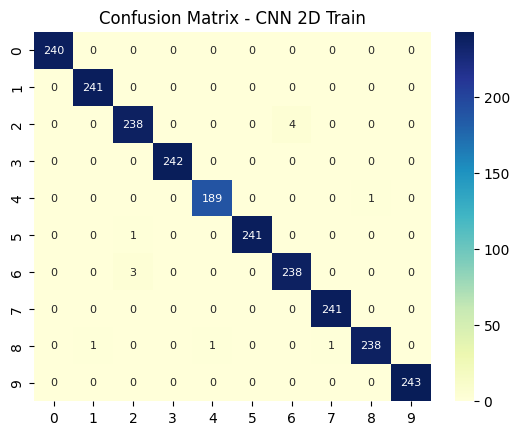

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


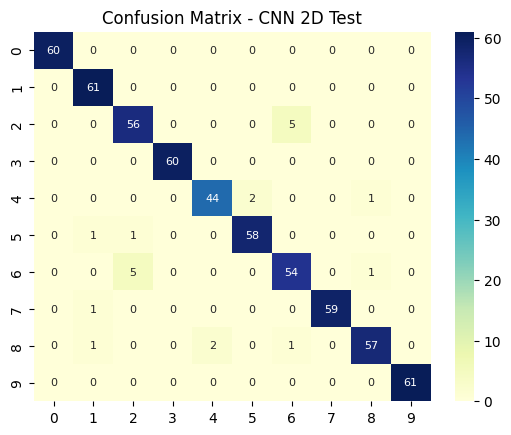

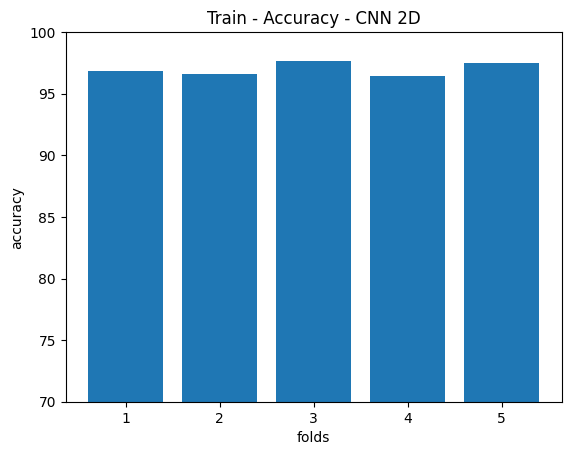

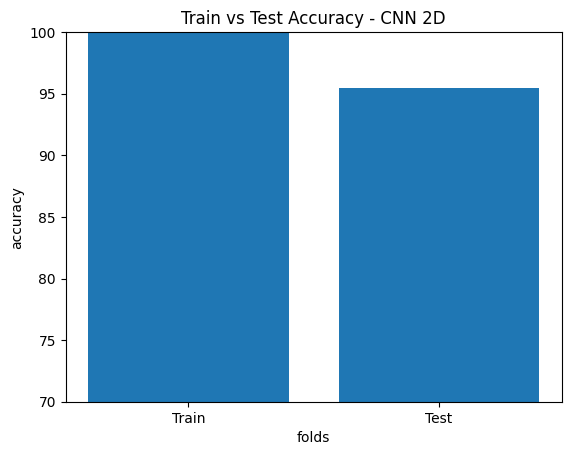

In [12]:
"""
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation
# -----------------------------------------------------------------------------
"""

# Classification_2D.model.summary()

CNN_2D_train_accuracy = np.average(accuracy_train)*100
print('CNN 2D train accuracy =', CNN_2D_train_accuracy)
# print(accuracy_train)

CNN_2D_val_accuracy = np.average(accuracy_val)*100
print('CNN 2D validation accuracy =', CNN_2D_val_accuracy)
# print(accuracy_val)

CNN_2D_test_accuracy = np.average(accuracy_test)*100
print('CNN 2D test accuracy =', CNN_2D_test_accuracy)
# print(accuracy_test)

# Evaluate the accuracy of the model on the test set
# CNN_2D_test_loss, CNN_2D_test_accuracy = Classification_2D.model.evaluate(X_2D_test, y_2D_test)
# CNN_2D_test_accuracy*=100
# print('CNN 2D test accuracy =', CNN_2D_test_accuracy)


def ConfusionMatrix(Model, X, y):
  y_pred = np.argmax(Model.predict(X), axis=1)
  ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
  return ConfusionMat

# Plot results - CNN 2D
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test') 
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test) , annot=True, fmt='d',annot_kws={"fontsize":8},cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1,kSplits+1),[i*100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70,100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1,2],[CNN_2D_train_accuracy,CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1,2],['Train', 'Test'])
plt.ylim([70,100])
plt.show()